In [88]:
import os
import time
import PIL
import pickle
import cv2

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tfc

from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

In [89]:
try: sess.close() 
except: pass
sess = tfc.InteractiveSession(config=tf.compat.v1.ConfigProto(log_device_placement=True))

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Device mapping: no known devices.
Num GPUs Available:  0


SystemError: GPU device not found

## Adjust CSV

In [90]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_labels = list(train_df.species.unique())
images = train_df['image']
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


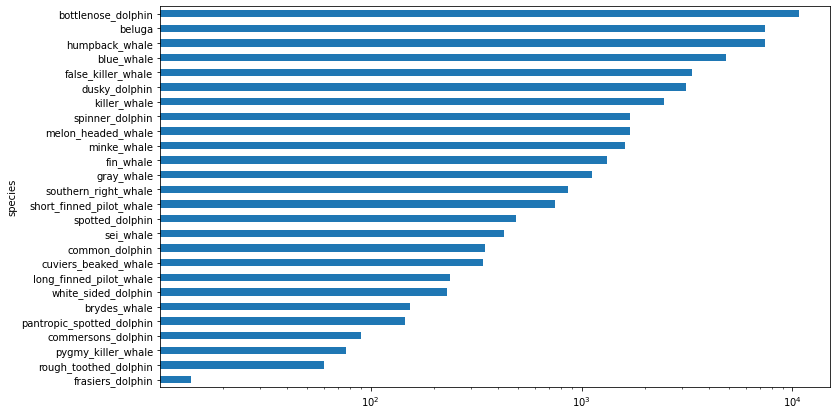

In [91]:
print(f"amount of species: {len(train_df.species.unique())}")
plt.figure(figsize=(12, 7))
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

In [92]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)
labels = train_df["species"]

##one-hot encode species
#train_df = pd.concat([train_df, pd.get_dummies(train_df["species"],prefix='species_',drop_first=True)], axis = 1)
#train_df.drop(['species'],axis=1, inplace=True)
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,0,cadddb1636b9
1,000562241d384d.jpg,1,1a71fbb72250
2,0007c33415ce37.jpg,2,60008f293a2b
3,0007d9bca26a99.jpg,3,4b00fe572063
4,00087baf5cef7a.jpg,1,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,4,5ac053677ed1
51029,fff8b32daff17e.jpg,17,1184686361b3
51030,fff94675cc1aef.jpg,7,5401612696b9
51031,fffbc5dd642d8c.jpg,4,4000b3d7c24e


## Resize Images
This helps the model fitting --> picture preprocessing gets less intensive

In [93]:
SOURCE = "train_images/"
RES = "train_images_res/"
try:
    os.makedirs(RES)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

for image in tqdm(images):
    savePath = RES + image  
    if not os.path.exists(savePath):
        imgPath = SOURCE + image
        im = Image.open(imgPath)
    
        resizedImage = im.resize((64, 64), PIL.Image.ANTIALIAS)
        resizedImage.save(savePath) 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51033/51033 [54:21<00:00, 15.65it/s]


In [94]:
full_img = list(map(RES.__add__, images))

## Input Pipeline

In [119]:
IMG_SIZE = 64
BATCH_SIZE = 512
AMT_CLASSES = len(train_df.species.unique())

In [120]:
    """
    @tf.function
    def process_img(img):
        img = tf.image.decode_jpeg(img, channels=3) 
        img = tf.image.convert_image_dtype(img, tf.float32) / 255
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bicubic', preserve_aspect_ratio=False, antialias=False,) 
        return img #tf.image.per_image_standardization(img)


    def opencv_process_img(path):
        file_name = tf.strings.split(path, "\\")[-1].numpy().decode()
        image = cv2.imread("train_images/"+file_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return tf.convert_to_tensor(image, dtype=tf.float32)



    def get_label(path):
        file_name= tf.strings.split(path, "\\")[-1]
        label= train_df[train_df["image"]==file_name]["species"].to_numpy().squeeze()
        return tf.convert_to_tensor(label)


    def process_path(path):
        if device_name != '/device:GPU:0':
            with tf.device('/cpu:0'):  
                img = process_img(tf.io.read_file(path))
        else:
            with tf.device('/device:GPU:0'):  
                img = process_img(tf.io.read_file(path))

        #img = opencv_process_img(path)
        label = get_label(path)
        return img, label
    """
    
    @tf.function
    def process_tuple(image,label):
        img = tf.io.read_file(image)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32) / 255
        #img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bicubic', preserve_aspect_ratio=False,antialias=False)
        return img, label

In [121]:
#dataset = tf.data.Dataset.list_files('train_images/*').map(lambda x: tf.py_function(process_path, [x], [tf.float32,tf.int64]))
#dataset = tf.data.Dataset.list_files('train_images/*').map(lambda x: tf.py_function(process_path, [x], [tf.float32,tf.int64]),num_parallel_calls=tf.data.AUTOTUNE)

dataset = tf.data.Dataset.from_tensor_slices((full_img, labels)).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

In [122]:
TRAIN_SPLIT = 0.7
VAL_TEST_SPLIT = (1-TRAIN_SPLIT)/2

image_count = dataset.cardinality().numpy()
train_size = int(image_count*TRAIN_SPLIT)
val_test_size = int(image_count*VAL_TEST_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_test_size)
test_ds = dataset.skip(train_size).skip(val_test_size)


train_batched = train_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_batched = val_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### Benchmark Dataset

In [123]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in tqdm(dataset):
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [126]:
benchmark_ds = dataset.take(1)
benchmark(benchmark_ds)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.45it/s]

Execution time: 0.07347650000156136


## Sequential Model

In [17]:
#generating model
model = keras.Sequential([
    layers.Flatten(input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(26, activation="softmax"),
])
model.summary()
plot_model(model,show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 512)               6291968   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 26)                1690      
                                                                 
Total params: 6,466,138
Trainable params: 6,466,138
Non-

In [18]:
#compiling model
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.SGD(),                    
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [19]:
model.fit(train_batched, epochs=25, validation_data = val_batched)

Epoch 1/25
 62/559 [==>...........................] - ETA: 11:51 - loss: 3.2145 - sparse_categorical_accuracy: 0.2072

KeyboardInterrupt: 

In [ ]:
eval = model.evaluate(test_batched, verbose = 0)

In [ ]:
with open('base_model', 'wb') as file:
    pickle.dump(model,file)

## CNN

In [127]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    data_augmentation = keras.Sequential(
        [
            #version tf 2.4.1: 
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )
    # Image augmentation block
    x = data_augmentation(inputs)
    activation_str = "elu"
    # Entry block
    #version tf 2.4.1
    #x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    #-----------------
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation(activation_str)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation(activation_str)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [128]:
#creating model
cnnmodel = create_model([IMG_SIZE, IMG_SIZE, 3], AMT_CLASSES)
cnnmodel.summary()
plot_model(cnnmodel,show_shapes=True, show_layer_names=True)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential_7 (Sequential)      (None, 64, 64, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 32, 32, 32)   896         ['sequential_7[0][0]']           
                                                                                                  
 batch_normalization_66 (BatchN  (None, 32, 32, 32)  128         ['conv2d_36[0][0]']              
 ormalization)                                                                              

 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 4, 4, 512)   0           ['batch_normalization_73[0][0]'] 
 )                                                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 4, 4, 512)    131584      ['add_25[0][0]']                 
                                                                                                  
 add_26 (Add)                   (None, 4, 4, 512)    0           ['max_pooling2d_26[0][0]',       
                                                                  'conv2d_40[0][0]']              
                                                                                                  
 activatio

In [129]:
#compiling model
cnnmodel.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.SGD(),                    
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [130]:
epochs = 15
if device_name != '/device:GPU:0':
    with tf.device('/cpu:0'):  
        history = cnnmodel.fit(train_batched, epochs = epochs, validation_data = val_batched)
else:
    with tf.device('/device:GPU:0'):  
        history = cnnmodel.fit(train_batched, epochs = epochs, validation_data = val_batched)



Epoch 1/15
70/70 [==============================] - 545s 8s/step - loss: 2.0051 - sparse_categorical_accuracy: 0.4665 - val_loss: 3.1791 - val_sparse_categorical_accuracy: 0.2081
Epoch 2/15
70/70 [==============================] - 507s 7s/step - loss: 1.5262 - sparse_categorical_accuracy: 0.5674 - val_loss: 3.1033 - val_sparse_categorical_accuracy: 0.2081
Epoch 3/15
70/70 [==============================] - 487s 7s/step - loss: 1.3714 - sparse_categorical_accuracy: 0.6011 - val_loss: 3.0248 - val_sparse_categorical_accuracy: 0.2081
Epoch 4/15
70/70 [==============================] - 486s 7s/step - loss: 1.2731 - sparse_categorical_accuracy: 0.6234 - val_loss: 2.9703 - val_sparse_categorical_accuracy: 0.2081
Epoch 5/15
70/70 [==============================] - 486s 7s/step - loss: 1.1994 - sparse_categorical_accuracy: 0.6443 - val_loss: 2.9935 - val_sparse_categorical_accuracy: 0.2081
Epoch 6/15
70/70 [==============================] - 485s 7s/step - loss: 1.1443 - sparse_categorical_accu

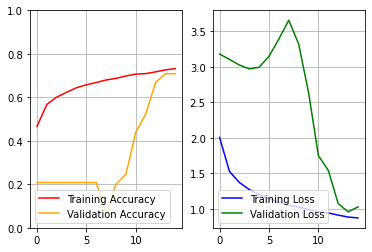

<Figure size 1080x576 with 0 Axes>

In [144]:
#visualize model performance
accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
fig, (ax1, ax2) = plt.subplots(1, 2)

plt.figure(figsize=(15, 8))
ax1.plot(range(epochs), accuracy, "r", label="Training Accuracy")
ax1.plot(range(epochs), val_accuracy, "orange", label="Validation Accuracy")
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.legend(loc="lower left")

ax2.plot(range(epochs), loss, "b", label="Training Loss")
ax2.plot(range(epochs), val_loss, "g", label="Validation Loss")
ax2.grid(True)
ax2.legend(loc="lower left")
#plt.gca().set_ylim(0, 2)


In [133]:
cnneval = cnnmodel.evaluate(test_batched, verbose = 0)

In [146]:
print("test loss, test acc:", cnneval)

test loss, test acc: [1.0559197664260864, 0.6948798298835754]


In [147]:
with open('cnn_model', 'wb') as file:
    pickle.dump(cnnmodel,file)

INFO:tensorflow:Assets written to: ram://51d2062b-612a-4726-8f32-81c4684b02f3/assets
